# Neural Magic Eye

This notebook provides a minimal working example of the autostereogram decoding demo in the preprint paper "NeuralMagicEye: Learning to See and Understand the Scene Behind an Autostereogram, arXiv:2012.15692."

[Project Page](https://jiupinjia.github.io/neuralmagiceye/) | [GitHub](https://github.com/jiupinjia/neural-magic-eye) | [Preprint](https://arxiv.org/abs/2012.15692)

In [ ]:
# Clone the repository
!git clone https://github.com/jiupinjia/neural-magic-eye.git 

Cloning into 'neural-magic-eye'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 76 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (76/76), done.


In [ ]:
cd neural-magic-eye

/content/neural-magic-eye/neural-magic-eye


In [ ]:
import argparse
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import stereogram as stgm
from networks import *

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# network configurations
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])

args.net_G = 'unet_256' # decoding network
args.norm_type = 'batch' # norm layer used
args.with_disparity_conv = True # insert a disparity convolution layer at the input end of the network
args.keep_aspect_ratio = False # whether to keep input aspect ratio when saving outputs
args.in_size = 256 # image size at the input end of the network
args.checkpoint_dir = r'./checkpoints_decode_sp_u256_bn_df' # dir to save checkpoints 

Download pretrained neural renderer.

In [ ]:
# Define some helper functions for downloading pretrained model
# taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
# download and unzip...
file_id = '1er9j1kX7bXljlj9vMwDr7Hb9zfL2XAns'
destination = './checkpoints_decode_sp_u256_bn_df.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
!unzip checkpoints_decode_sp_u256_bn_df.zip

Archive:  checkpoints_decode_sp_u256_bn_df.zip
   creating: checkpoints_decode_sp_u256_bn_df/
  inflating: checkpoints_decode_sp_u256_bn_df/best_ckpt.pt  
  inflating: checkpoints_decode_sp_u256_bn_df/last_ckpt.pt  
  inflating: checkpoints_decode_sp_u256_bn_df/train_acc.npy  
  inflating: checkpoints_decode_sp_u256_bn_df/val_acc.npy  


Select an input image

In [ ]:
args.in_file = r'./test_images/buddha.jpg' # path to input photo

Let's see what the input autostereogram image look like

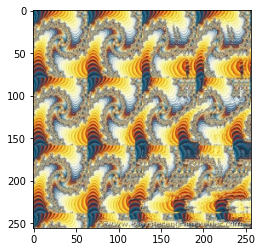

In [ ]:
img_org = cv2.imread(args.in_file, cv2.IMREAD_COLOR)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
org_h, org_w, c = img_org.shape
img_ = cv2.resize(img_org, (args.in_size, args.in_size), cv2.INTER_CUBIC)
plt.imshow(img_)

Define the network and load the predifined checkpoint

In [ ]:
print('loading best checkpoint...')
net_G = define_G(args).to(device)
checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'best_ckpt.pt'),
                        map_location=None if torch.cuda.is_available() else device)
net_G.load_state_dict(checkpoint['model_G_state_dict'])
net_G.eval()

loading best checkpoint...
initialize network with normal


Sequential(
  (0): DisparityConv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (1): ReLU()
  (2): UnetGenerator(
    (conv_in): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (model): UnetSkipConnectionBlock(
      (model): Sequential(
        (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): UnetSkipConnectionBlock(
          (model): Sequential(
            (0): LeakyReLU(negative_slope=0.2, inplace=True)
            (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): UnetSkipConnectionBlock(
              (model): Sequential(
                (0): LeakyReLU(negative_slope=0.2, inplace=True)
                (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (2): BatchNorm2d(128, eps=1e-05

Convert the image to gpu tensor and feed it to the decoding network

In [ ]:
img = torch.tensor(img_).permute([2, 0, 1]).unsqueeze(0).to(device)
G_pred = net_G(img)
out = G_pred.detach().squeeze().cpu().numpy()
out = np.clip(out, a_min=0, a_max=1.0)
out = utils.normalize(out, p_min=0.02, p_max=0.02)

Now we have the decoding output!

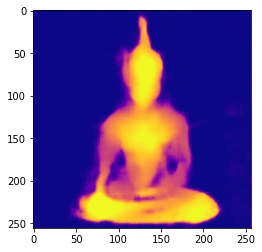

In [ ]:
plt.imshow(out, cmap='plasma')

We can even try on videos

Select your input autostereogram video (.mp4 or .gif)

In [ ]:
args.in_file = r'./test_videos/bunny.mp4' # path to input video

Get video parameters, run the above decoding process on each video frame and save the results in a result buffer

In [ ]:
cap = cv2.VideoCapture(args.in_file)
m_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
org_w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
org_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buff = [] # buffer to save the results
for i in range(m_frames):
    # read a frame and resize
    rt, img_org = cap.read()
    if rt:
        img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
        org_h, org_w, c = img_org.shape
        img_ = cv2.resize(img_org, (args.in_size, args.in_size), cv2.INTER_CUBIC)

        # run a forward pass
        img = torch.tensor(img_).permute([2, 0, 1]).unsqueeze(0).to(device)
        G_pred = net_G(img)
        out = G_pred.detach().squeeze().cpu().numpy()
        out = np.clip(out, a_min=0, a_max=1.0)
        out = utils.normalize(out, p_min=0.02, p_max=0.02)

        # Apply the colormap like a function to any array:
        cm = plt.get_cmap('plasma')
        out = cm(out)[:,:,0:3]

        # concate the results with the input and save to the buffer
        cat = np.concatenate([img_, out], axis=1)
        buff.append(cat)

    print('processing %d / %d frames' % (i, m_frames))
print('done.')

processing 0 / 68 frames
processing 1 / 68 frames
processing 2 / 68 frames
processing 3 / 68 frames
processing 4 / 68 frames
processing 5 / 68 frames
processing 6 / 68 frames
processing 7 / 68 frames
processing 8 / 68 frames
processing 9 / 68 frames
processing 10 / 68 frames
processing 11 / 68 frames
processing 12 / 68 frames
processing 13 / 68 frames
processing 14 / 68 frames
processing 15 / 68 frames
processing 16 / 68 frames
processing 17 / 68 frames
processing 18 / 68 frames
processing 19 / 68 frames
processing 20 / 68 frames
processing 21 / 68 frames
processing 22 / 68 frames
processing 23 / 68 frames
processing 24 / 68 frames
processing 25 / 68 frames
processing 26 / 68 frames
processing 27 / 68 frames
processing 28 / 68 frames
processing 29 / 68 frames
processing 30 / 68 frames
processing 31 / 68 frames
processing 32 / 68 frames
processing 33 / 68 frames
processing 34 / 68 frames
processing 35 / 68 frames
processing 36 / 68 frames
processing 37 / 68 frames
processing 38 / 68 fra

Check out your animated results

In [ ]:
# Check out your results at './SkyAR/demo.avi' and './SkyAR/demo-cat.avi'. 
# Download them and enjoy.

# If you would like to pre-view your results. Run the following to see the animated 
# results of the first 40 frames.

import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,4))
plt.axis('off')
ims = [[plt.imshow(img, animated=True)] for img in buff]
ani = animation.ArtistAnimation(fig, ims, interval=50)

HTML(ani.to_jshtml())